# <div style="text-align: center">Random Forests - KS Mapping</div> 

# Gaussian Potential - to - Energy

## Setup

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from KRR_reproduce import *

## Edward

In [2]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

plt.style.use('ggplot')
ed.set_seed(42)

/anaconda3/envs/edward/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


# Separation-to-Energy

In [3]:
# setup
SIM_NO = 150
SEED = 42
TEST_SIZE = 0.1
GRID_SPACE = 0.08


# path to data
os.environ['PROJDIR'] = '/Users/simonbatzner1/Desktop/Research/Research_Code/ML-electron-density'
STR_PREF = os.environ['PROJDIR'] + '/data/H2_DFT/temp_data/store/'


## Load data

In [4]:
# LOAD DATA
ens = []
seps = []
fours = []

for n in range(SIM_NO):
    # load separation, energy, and density
    sep = np.load(STR_PREF + 'sep_store/sep' + str(n) + '.npy')
    en = np.load(STR_PREF + 'en_store/en' + str(n) + '.npy')
    four = np.load(STR_PREF + 'four_store/four' + str(n) + '.npy')

    # put results in a nicer format
    sep = np.reshape(sep, (1,))[0]
    en = np.reshape(en, (1,))[0]['energy']
    four = np.real(four)

    # store quantities
    ens.append(en)
    seps.append(sep)
    fours.append(four) 

## Setup training and test data

In [5]:
# setup training and test datas
data = seps
labels = ens
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=TEST_SIZE, random_state=SEED)

x_train = np.array(x_train)
x_train = x_train.reshape(-1,1)
x_test = np.array(x_test)
x_test = x_test.reshape(-1,1)
y_train = np.array(y_train)
y_test = np.array(y_test)
    
N = int(x_train.shape[0])
D = int(x_train.shape[1])

x_train = x_train.astype(np.float32).reshape((N, 1))
y_train = y_train.astype(np.float32)
print(x_train.shape)

(135, 1)


## Build Edward NN

In [6]:
def neural_network(x, W_0, W_1, W_2, b_0, b_1, b_2):
    # this is based on the tensorflow schema
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.tanh(tf.matmul(h, W_1) + b_1)
    h = tf.matmul(h, W_2) + b_2
    return tf.reshape(h, [-1]) 

In [7]:
N = int(x_train.shape[0])
D = int(x_train.shape[1])

print("N = {}".format(N))
print("D = {}".format(D))

h1, h2 = 5, 5

W_0 = Normal(loc=tf.zeros([D, h1]), scale=tf.ones([D, h1]))
W_1 = Normal(loc=tf.zeros([h1, h2]), scale=tf.ones([h1, h2]))
W_2 = Normal(loc=tf.zeros([h2, 1]), scale=tf.ones([h2, 1]))
b_0 = Normal(loc=tf.zeros(h1), scale=tf.ones(h1))
b_1 = Normal(loc=tf.zeros(h2), scale=tf.ones(h2))
b_2 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = x_train
y = Normal(loc=neural_network(x, W_0, W_1, W_2, b_0, b_1, b_2),
           scale=0.1 * tf.ones(N))

N = 135
D = 1


In [8]:
qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [D, h1]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [D, h1])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [h1, h2]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [h1, h2])))
qW_2 = Normal(loc=tf.get_variable("qW_2/loc", [h2, 1]),
              scale=tf.nn.softplus(tf.get_variable("qW_2/scale", [h2, 1])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [h1]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [h1])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [h2]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [h2])))
qb_2 = Normal(loc=tf.get_variable("qb_2/loc", [1]),
              scale=tf.nn.softplus(tf.get_variable("qb_2/scale", [1])))

In [9]:
# Sample functions from variational model to visualize fits.
rs = np.random.RandomState(0)
inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
x = tf.expand_dims(inputs, 1)

# we just define some random varialbes for the weights and biases; we now sample from them randomly and then pass
# the samples to our neural_network() function that constructs a network from this; we do that a total of 10 times
mus = tf.stack(
    [neural_network(x, qW_0.sample(), qW_1.sample(), qW_2.sample(),
                    qb_0.sample(), qb_1.sample(), qb_2.sample())
     for _ in range(10)])

## Viz

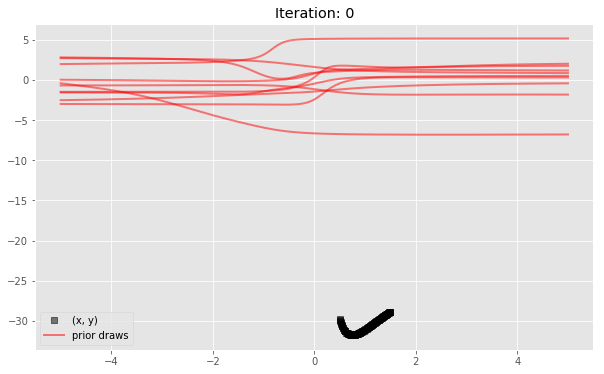

In [10]:
# FIRST VISUALIZATION (prior)
# this is what our models look like without having seen the data that we want to train it on; that means, this is
# what the output of 10 different neural nets looks like, where for each of them their weights and biases
# have been drawn from the probability distributions we defined above
sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.legend()
plt.show()

## Perform VI

In [11]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1, 
                     W_2: qW_2, b_2: qb_2}, data={y: y_train})
inference.run(n_iter=100000, n_samples=135)

/anaconda3/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


 18000/100000 [ 18%] █████                          ETA: 5084s | Loss: 5672.059

KeyboardInterrupt: 

## Draw some neural nets from the posterior

In [ ]:
# SECOND VISUALIZATION (posterior)
outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([0, 2])
ax.set_ylim([-32, -28])
ax.legend()
plt.show()